In [1]:
%load_ext notexbook

%texify -fs 18 

# Methods for time series forecasting

There are many methods that we can use for time series forecasting and there is not a clear winner. Model selection should always depend on how you data look and what are you trying to achieve. Some models may be more robust against outliers but perform worse than the more sensible and could still be the best choice depending on the use case.

When looking at your data the main split is wether we have extra regressors (features) to our time series or just the series. Based on this we can start exploring different methods for forecasting and their performance in different metrics.

In this section we will show models for both cases, time series with and without extra regressors.

**Prepare data before modeling**

In [2]:
import numpy as np
import pandas as pd
import statsmodels as sm

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 123456
np.random.seed(RANDOM_SEED)
plt.style.use('bmh')

In [3]:
air_pollution = pd.read_csv('air_pollution.csv', parse_dates=['date'])
air_pollution.set_index('date', inplace=True)
air_pollution.head()

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
date,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,10.041667
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333


In [4]:
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

split_date = '2014-01-01'
df_training = air_pollution.loc[air_pollution.index <= split_date]
df_test = air_pollution.loc[air_pollution.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

1461 days of training data 
 364 days of testing data 


It is also very important to include some naive forecast as the series mean or previous value to make sure our models perform better than the simplest of the simplest. We dont want to introduce any complexity if it does not provides any performance gain.

In [5]:
from tqdm import tqdm

from utils.metrics import evaluate
from utils.plots import bar_metrics

In [6]:
# Also add the naive mean average value
mean = df_training.pollution_today.mean()
mean = np.array([mean for u in range(len(df_test))])
resultsDict['Naive mean'] = evaluate(df_test.pollution_today, mean)
predictionsDict['Naive mean'] = mean
resultsDict['Yesterdays value'] = evaluate(
    df_test.pollution_today, df_test.pollution_yesterday)
predictionsDict['Yesterdays value'] = df_test.pollution_yesterday.values

## Univariate-time-series-forecasting

In this section we will focus on time series forecasting methods capable of only looking at the target variable. This means no other regressors (more variables) can be added into the model.

### Simple Exponential Smoothing (SES)

The Simple Exponential Smoothing (SES) method models the next time step as an exponentially weighted linear function of observations at prior time steps. This method expects our time series to be non stationary in order to perform adecuately (no trend or seasonality)

In [7]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train.pollution_today)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['SES'] = yhat.values

100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:09<00:00, 37.25it/s]


### Autoregressive integrated moving average (ARIMA)

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

* **Number of AR** (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
* **Number of Differences** (d): d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
* **Number of MA** (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

**Tuning ARIMA parameters**

Non stationarity series will require level of differencing (d) >0 in ARIMA
Select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively, using PACF, ACF plots
AUTOARIMA

Note: A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

In [10]:
from statsmodels.tsa.arima.model import ARIMA

In [11]:
# ARIMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARIMA(temp_train.pollution_today, order=(1, 0, 0))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:41<00:00,  8.80it/s]


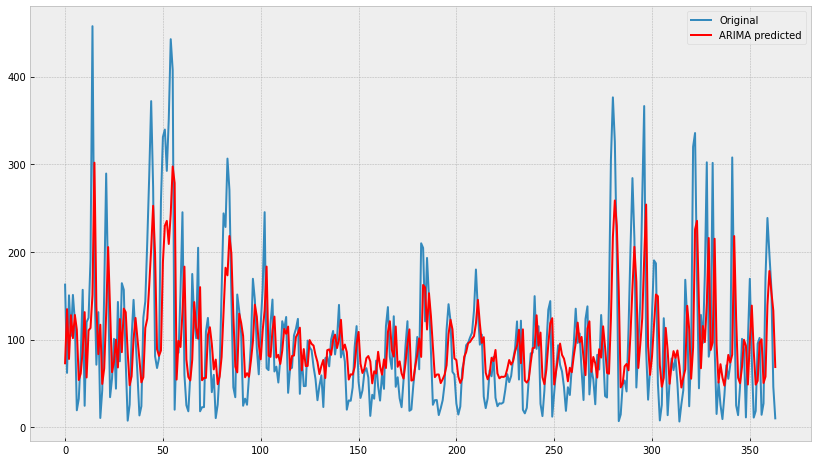

In [12]:
plt.figure(figsize=(14, 8))
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat.values, color='red', label='ARIMA predicted')
plt.legend()
plt.show()

#### Auto ARIMA

In [13]:
import pmdarima as pm

In [14]:
# building the model
autoModel = pm.auto_arima(df_training.pollution_today, trace=True,
                          error_action='ignore', suppress_warnings=True, seasonal=False)
autoModel.fit(df_training.pollution_today)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.42 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18232.724, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=16461.265, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=17191.945, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=16462.630, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=16462.086, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=16455.385, Time=0.54 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=1.26 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=16266.588, Time=0.56 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=16869.411, Time=0.24 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=16217.321, Time=0.98 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=16711.266, Time=0.34 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=1.83 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=1.83 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1

ARIMA(order=(0, 0, 3), scoring_args={}, suppress_warnings=True)

In [15]:
order = autoModel.order
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARIMA(temp_train.pollution_today, order=order)
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoARIMA {0}'.format(order)] = evaluate(
    df_test.pollution_today, yhat)
predictionsDict['AutoARIMA {0}'.format(order)] = yhat.values

100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [02:38<00:00,  2.29it/s]


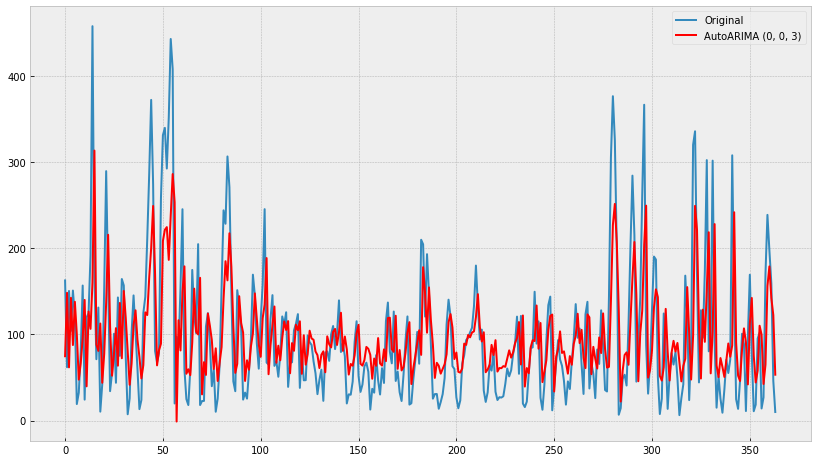

In [16]:
plt.figure(figsize=(14, 8))
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat.values, color='red', label='AutoARIMA {0}'.format(order))
plt.legend()
plt.show()

### Seasonal Autoregressive Integrated Moving-Average (SARIMA)
Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

__Trend Elements:__

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

__Seasonal Elements:__

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.

__SARIMA notation:__
`SARIMA(p,d,q)(P,D,Q,m)`

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [18]:
# SARIMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = SARIMAX(temp_train.pollution_today, order=(
        1, 0, 0), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SARIMAX'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['SARIMAX'] = yhat.values

100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:28<00:00, 12.97it/s]


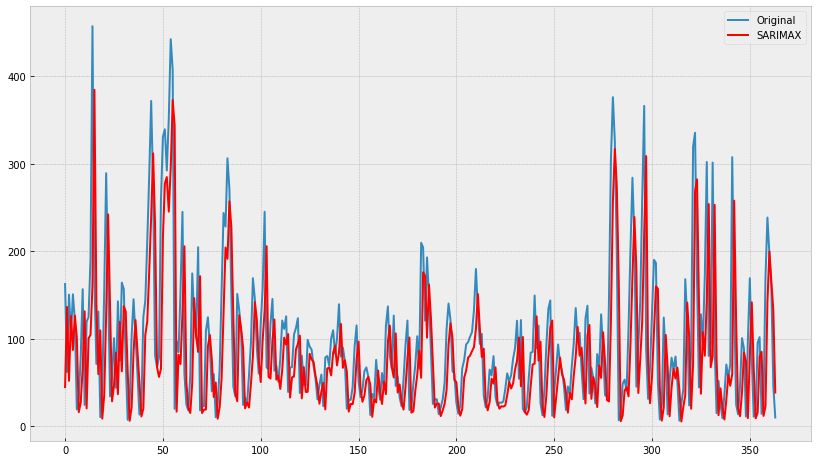

In [19]:
plt.figure(figsize=(14, 8))
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat.values, color='red', label='SARIMAX')
plt.legend()
plt.show()

#### Auto - SARIMA

[auto_arima documentation for selecting best model](https://www.alkaline-ml.com/pmdarima/tips_and_tricks.html)

In [20]:
# building the model
autoModel = pm.auto_arima(df_training.pollution_today, trace=True, error_action='ignore',
                          suppress_warnings=True, seasonal=True, m=6, stepwise=True)
autoModel.fit(df_training.pollution_today)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[6] intercept   : AIC=16199.948, Time=4.59 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=16788.406, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=16229.161, Time=0.46 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=16265.917, Time=1.03 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=18232.724, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[6] intercept   : AIC=16200.349, Time=1.07 sec
 ARIMA(2,0,2)(1,0,0)[6] intercept   : AIC=16200.355, Time=1.00 sec
 ARIMA(2,0,2)(2,0,1)[6] intercept   : AIC=16203.879, Time=3.33 sec
 ARIMA(2,0,2)(1,0,2)[6] intercept   : AIC=16203.861, Time=4.12 sec
 ARIMA(2,0,2)(0,0,0)[6] intercept   : AIC=16198.453, Time=0.59 sec
 ARIMA(1,0,2)(0,0,0)[6] intercept   : AIC=16196.487, Time=1.82 sec
 ARIMA(1,0,2)(1,0,0)[6] intercept   : AIC=16198.378, Time=3.24 sec
 ARIMA(1,0,2)(0,0,1)[6] intercept   : AIC=16198.371, Time=3.34 sec
 ARIMA(1,0,2)(1,0,1)[6] intercept   : AIC=16200.253, Time=2.45 sec
 ARIMA(0,0,2)(0,0,0

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(0, 0, 0, 6),
      suppress_warnings=True)

In [21]:
order = autoModel.order
seasonalOrder = autoModel.seasonal_order
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = SARIMAX(temp_train.pollution_today, order=order,
                    seasonal_order=seasonalOrder)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoSARIMAX {0},{1}'.format(order, seasonalOrder)] = evaluate(
    df_test.pollution_today, yhat.values)
predictionsDict['AutoSARIMAX {0},{1}'.format(
    order, seasonalOrder)] = yhat.values

100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:49<00:00,  7.34it/s]


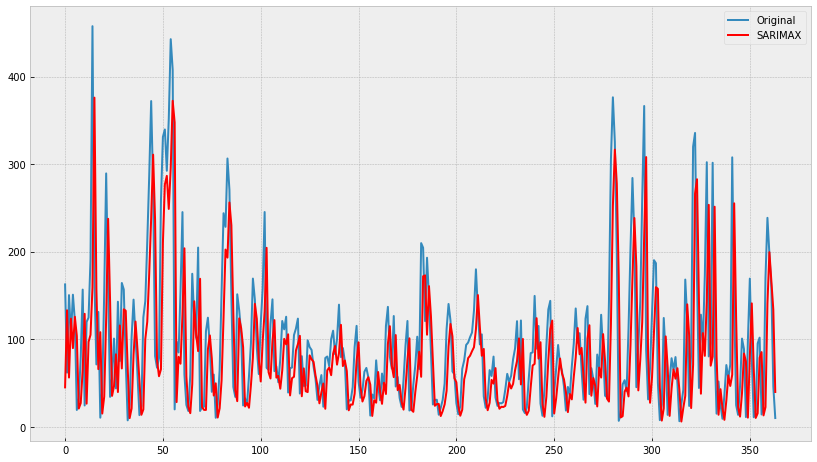

In [22]:
plt.figure(figsize=(14, 8))
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat.values, color='red', label='SARIMAX')
plt.legend()
plt.show()

### Prophet

Prophet is a model released by [facebook](https://github.com/facebook/prophet). Is essentially a curve fitting approach, very similar in spirit to how **BSTS** (i.e. _Bayesian Structural Time Series_) models trend and seasonality, except that it uses generalized additive models instead of a state-space representation to describe each component.


In [23]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [24]:
# Prophet needs some specifics data stuff, coment it here
prophet_training = df_training.rename(
    columns={'pollution_today': 'y'})  # old method
prophet_training['ds'] = prophet_training.index
prophet_training.index = pd.RangeIndex(len(prophet_training.index))

prophet_test = df_test.rename(columns={'pollution_today': 'y'})  # old method
prophet_test['ds'] = prophet_test.index
prophet_test.index = pd.RangeIndex(len(prophet_test.index))

In [25]:
prophet = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    holidays_prior_scale=20,
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False
).add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=55
).add_seasonality(
    name='daily',
    period=1,
    fourier_order=15
).add_seasonality(
    name='weekly',
    period=7,
    fourier_order=25
).add_seasonality(
    name='yearly',
    period=365.25,
    fourier_order=20
).add_seasonality(
    name='quarterly',
    period=365.25/4,
    fourier_order=55
).add_country_holidays(country_name='China')

In [26]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet univariate'] = evaluate(
    df_test.pollution_today, yhat.yhat.values)
predictionsDict['Prophet univariate'] = yhat.yhat.values

17:01:01 - cmdstanpy - INFO - Chain [1] start processing
17:01:02 - cmdstanpy - INFO - Chain [1] done processing


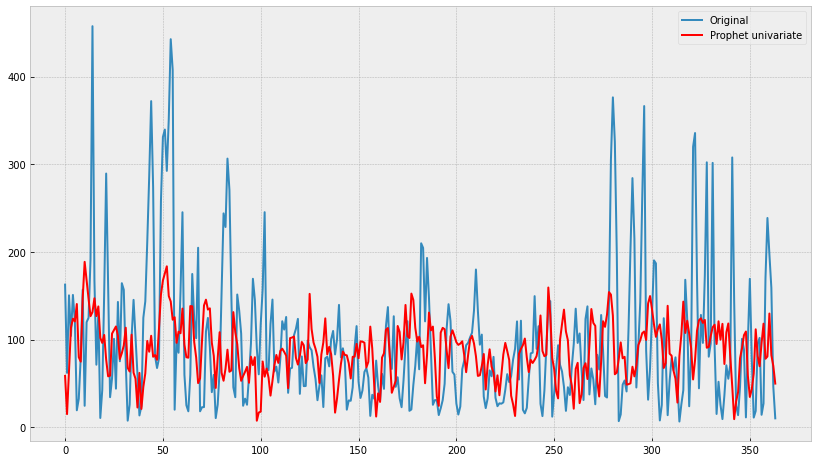

In [27]:
plt.figure(figsize=(14, 8))
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat.yhat, color='red', label='Prophet univariate')
plt.legend()

## Multivariate time series forecasting

In [28]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [29]:
from sklearn.preprocessing import StandardScaler

In [30]:
X_train_df, y_train = create_time_features(
    df_training, target='pollution_today')
X_test_df, y_test = create_time_features(df_test, target='pollution_today')

scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

### Linear models

In [31]:
from sklearn import linear_model

#### Bayesian regression

In [32]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['BayesianRidge'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['BayesianRidge'] = yhat

#### Lasso

In [33]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Lasso'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['Lasso'] = yhat

### Tree models

#### Randomforest

In [34]:
from sklearn.ensemble import RandomForestRegressor

In [35]:
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['Randomforest'] = yhat

#### Lightgbm

A tree gradient boosting model by [microsoft](https://github.com/microsoft/LightGBM)

In [36]:
import lightgbm as lgb

In [37]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train, y_train)
yhat = lightGBM.predict(X_test)
resultsDict['Lightgbm'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['Lightgbm'] = yhat

### Support vector machines

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.

The advantages of support vector machines are:

- Effective in high dimensional spaces.
- Still effective in cases where number of dimensions is greater than the number of samples.
- Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
- Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

The disadvantages of support vector machines include:

- If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.

- SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation (see Scores and probabilities, below).

In [38]:
from sklearn import svm

In [39]:
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM RBF'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['SVM RBF'] = yhat

### Nearest neighbors

In [40]:
from sklearn.neighbors import KNeighborsRegressor

In [41]:
reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Kneighbors'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['Kneighbors'] = yhat

## Plot Results

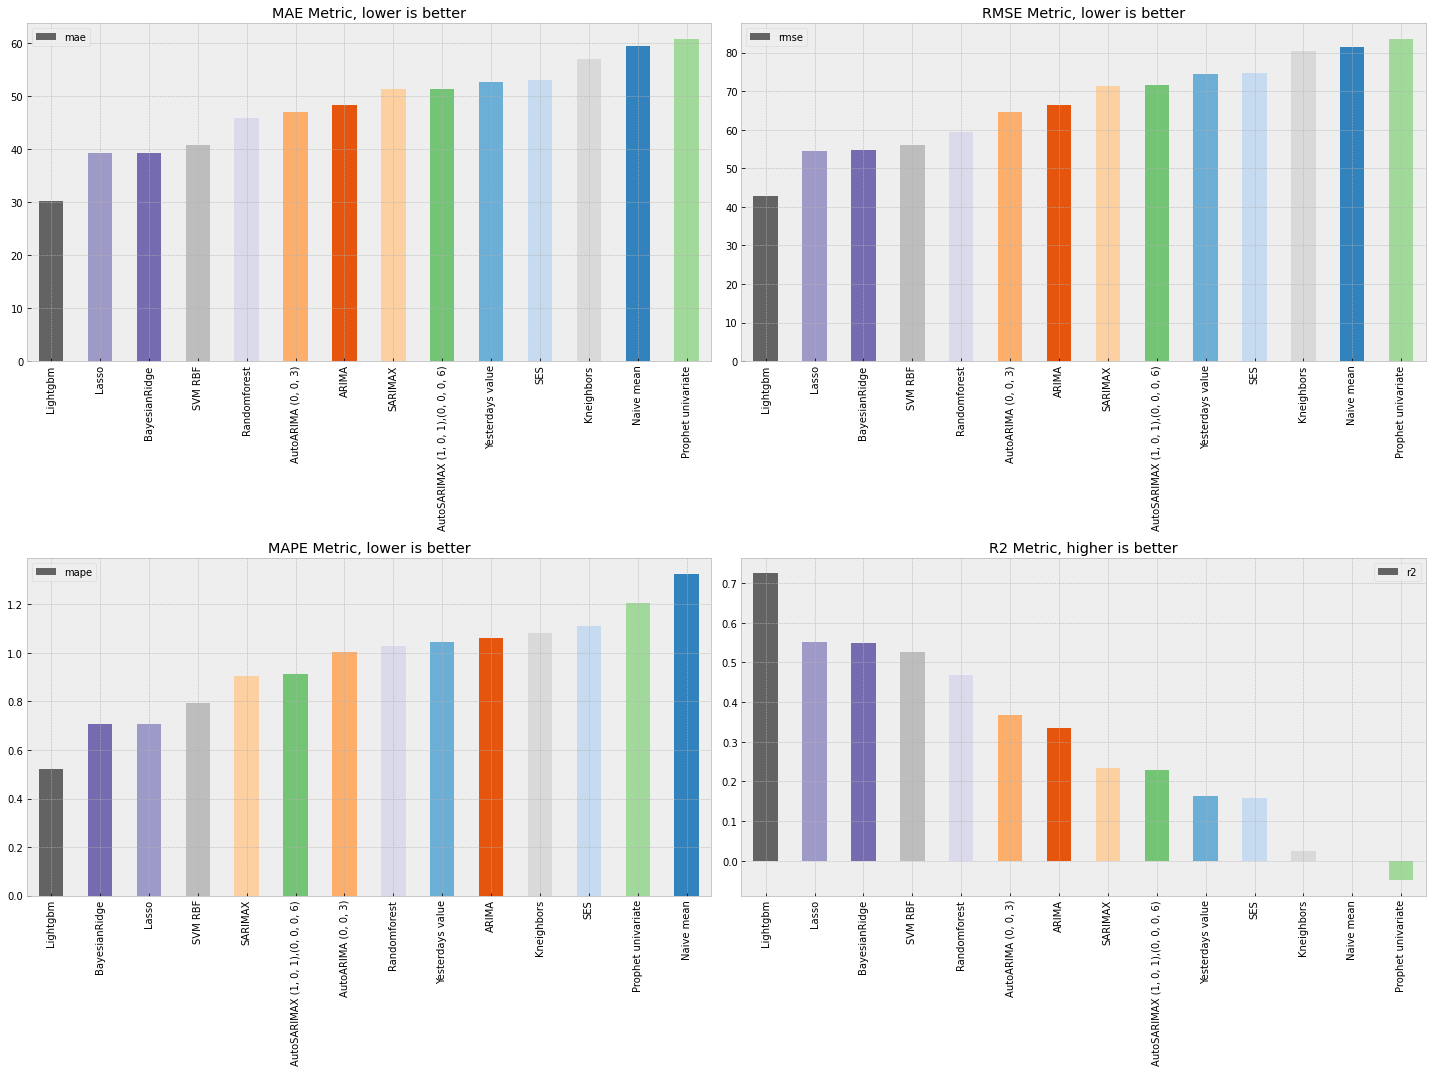

In [43]:
bar_metrics(resultsDict)